# Work Trial - Stefan Heimersheim

## Instructions
- [ ] Save a copy of this Colab notebook to your own drive  (File > Save a copy in Drive)
  - [ ] Update the sharing settings to “anyone with the link can comment."
- [ ] Create a separate Google doc to present your results and take notes, while completing the tasks in your copy of the Colab notebook.
  - [ ] Update the sharing settings to “anyone with the link can comment."
- [ ] Set a timer and start investigating. Do not spend more than 3 hours on this task. State the time spent on this work trial at the top of your Google doc.
- [ ] Submit both links in the MARS application.

# Background

This is a setting from one of my previous mentoring groups. We were investigating a variation of the model of "Compressed Computation" in [Braun et al. 2025](https://arxiv.org/abs/2501.14926) (section 3.2, no need to read).
The paper investigated a model that was able to learn 100 ReLU functions (labels) despite having only 50 neurons (actual ReLUs), when the inputs were sparse.

We generalized the setting and looked at non-sparse inputs. We want to see what the model learns if there is no sparsity. You will later see (Part 2) that this model _still_ does better than we naively expected. The naive expectation was that the MLP layer will simply ignore half of the features, and perfectly represent the other half. However, we found that, if the inputs are dense, the model achieves a lower loss than this (naive) model.

In this task I provide you with the trained model, and ask you to investigate what it's doing. Which features is it representing, what is it doing with the other ones, etc. Ultimately we want to figure out what "trick" the model is using to perform better than our naive expectation.

I do not expect you to conclude this investigation as part of the work trial. Instead consider this as a first step where you start the investigation, obtain some results, and present them to me (imagine sending a couple of Slack messages, or presenting your results at the next mentoring call).

# Setup code (imports)

In [ ]:
import pickle
from dataclasses import dataclass
from pathlib import Path

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn

# Model & training code

The following code contains a mostly-standard MLP (but **without biases**) with a skip connection, i.e. a residual network. If you're familiar with transformers, this looks basically like a 1-layer transformer (without attention, and without the sequence dimension).

```
    x ∈ R^(batch x n_features)
         |
         v
    +----------+
    |   W_E    |  Embedding matrix (fixed)
    +----------+
         |
         v
    residual ∈ R^(batch x d_embed)
         |
         |------------+
         v            |
    +----------+      |
    |   W_in   |      |  MLP input weights (trainable)
    +----------+      |
         |            |
         v            |
    pre_act ∈ R^(batch x d_mlp)
         |            |
         v            |
    +----------+      |
    |   ReLU   |      |  ReLU activation
    +----------+      |
         |            |
         v            |
    post_act ∈ R^(batch x d_mlp)
         |            |
         v            |
    +----------+      |
    |  W_out   |      |  MLP output weights (trainable)
    +----------+      |
         |            |
         v            |
    mlp_out ∈ R^(batch x d_embed)
         |            |
         +<-----------+
         |
         v
    residual ∈ R^(batch x d_embed)
         |
         v
    +----------+
    |   W_E.T  |  Unembedding matrix (fixed)
    +----------+
         |
         v
    out ∈ R^(batch x n_features)
```

## Model and training code

The model code here should match the description above.

You don't need to read the training code.

In [ ]:
@dataclass
class Config:
    """Configuration for the ResidualMLP model and training."""

    # Model parameters
    n_features: int = 100
    d_embed: int = 1000
    d_mlp: int = 50
    # Training parameters
    batch_size: int = 2048
    steps: int = 1_000
    lr: float = 3e-3
    print_freq: int = 50


class ResidualMLPModel(nn.Module):
    """A simple residual MLP model with fixed embeddings and one layer.

    Note that the model has no biases."""

    def __init__(self, config: Config):
        super().__init__()
        n_features, d_embed, d_mlp = config.n_features, config.d_embed, config.d_mlp
        # The embedding vectors are random unit vectors
        W_E = torch.randn(n_features, d_embed)
        W_E = F.normalize(W_E, dim=1)
        self.register_buffer("W_E", W_E)

        # The MLP weights are trained
        self.W_in = nn.Parameter(torch.empty(d_embed, d_mlp))
        self.W_out = nn.Parameter(torch.empty(d_mlp, d_embed))
        nn.init.xavier_normal_(self.W_in)
        nn.init.xavier_normal_(self.W_out)

    def forward(self, x: Tensor) -> Tensor:
        residual = einops.einsum(x, self.W_E, "batch n_features, n_features d_embed -> batch d_embed")
        pre_act = einops.einsum(residual, self.W_in, "batch d_embed, d_embed d_mlp -> batch d_mlp")
        post_act = F.relu(pre_act)
        mlp_out = einops.einsum(post_act, self.W_out, "batch d_mlp, d_mlp d_embed -> batch d_embed")
        residual = residual + mlp_out
        out = einops.einsum(residual, self.W_E, "batch d_embed, n_features d_embed -> batch n_features")
        return out


class UniformFeatureDataset:
    """Dataset of uniformly distributed features.

    The inputs X (batch x n_features) are uniformly distributed in the range [-1, 1]. The labels Y (batch x n_features) are X + ReLU(X).
    """

    def __init__(self, config: Config):
        self.n_features = config.n_features

    def generate_batch(self, batch_size: int, resid: bool = True) -> tuple[Tensor, Tensor]:
        batch = 2 * torch.rand((batch_size, self.n_features)) - 1
        labels = F.relu(batch) + batch
        return batch, labels


def train(config: Config, model: ResidualMLPModel, dataset: UniformFeatureDataset) -> None:
    torch.manual_seed(42)
    np.random.seed(42)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
    dataset = UniformFeatureDataset(config)

    for step in range(config.steps):
        batch, labels = dataset.generate_batch(config.batch_size)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1))
        loss.backward()
        optimizer.step()

        if step % config.print_freq == 0 or step == config.steps - 1:
            print(f"Step {step} loss: {loss.item():.2e}")

    return model


def evaluate(model: ResidualMLPModel, dataset: UniformFeatureDataset, batch_size: int = 10_000) -> float:
    with torch.no_grad():
        batch, labels = dataset.generate_batch(batch_size)
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1)).item()
    return loss

# Training
The following cell runs the training code (should take less than a minute, you can just use a CPU).

It should automatically load the model the 2nd time you run this cell, otherwise adjust the code below.

In [ ]:
config = Config(steps=500, batch_size=2048)

model_path = Path("model.pkl")
if not model_path.exists():
    model = ResidualMLPModel(config)
    dataset = UniformFeatureDataset(config)
    train(config, model, dataset)
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
else:
    with open(model_path, "rb") as f:
        model = pickle.load(f)
        dataset = UniformFeatureDataset(config)

print("Trained model loss:", evaluate(model, dataset))

Step 0 loss: 2.01e-01
Step 50 loss: 6.99e-02
Step 100 loss: 6.27e-02
Step 150 loss: 6.20e-02
Step 200 loss: 6.09e-02
Step 250 loss: 6.00e-02
Step 300 loss: 5.86e-02
Step 350 loss: 5.80e-02
Step 400 loss: 5.69e-02
Step 450 loss: 5.61e-02
Step 499 loss: 5.56e-02
Trained model loss: 0.05555826053023338


# Task (part 1)

This model has only 50 neurons, but we trained it on 100 input features. We want to see what the model has learned.

In this exercise I want to test how well you can iterate on results and find good ways to extract and present information. The suggestions below are what I might say during a mentoring call. You don't have to stick to them exactly, and you don't have to stop there!

> I think we should start by measuring the loss per feature (for the different features), can you plot this? And can you plot the input-output response for each feature (where input feature = output feature), maybe in isolation (only that feature non-zero) or together with other features active.

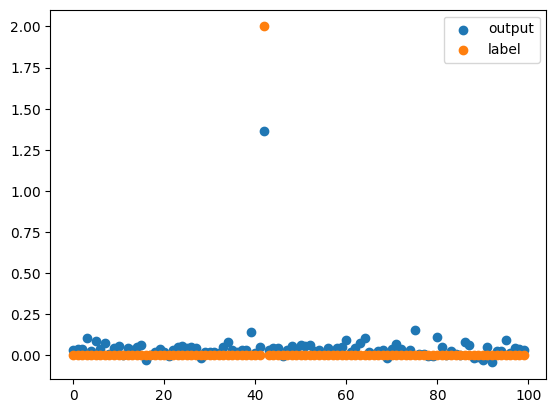

In [ ]:
# Example code how you might interact with the model
batch_size = 1
batch = torch.zeros(batch_size, config.n_features)
batch[:, 42] = 1
label = F.relu(batch) + batch
out = model(batch).detach()
plt.scatter(np.arange(config.n_features), out[0], label="output")
plt.scatter(np.arange(config.n_features), label[0], label="label")
plt.legend()
plt.show()

# Task (part 2)

In [ ]:
class NaiveSolution(nn.Module):
    """A simple ResidualMLP model with no embeddings (W_E = I) and identity MLP weights"""

    def __init__(self, config: Config):
        super().__init__()
        self.W_in = nn.Parameter(torch.eye(config.n_features, config.d_mlp))
        self.W_out = nn.Parameter(torch.eye(config.d_mlp, config.n_features))

    def forward(self, x: Tensor) -> Tensor:
        pre_act = einops.einsum(x, self.W_in, "batch n_features, n_features d_mlp -> batch d_mlp")
        post_act = F.relu(pre_act)
        out = einops.einsum(post_act, self.W_out, "batch d_mlp, d_mlp n_features -> batch n_features")
        return out + x


naive_model = NaiveSolution(config)
print("Naive model loss:", evaluate(naive_model, dataset))

Naive model loss: 0.08340801298618317



The model we trained appears to achieve a better loss than the naive solution (representing just half the features, which should get a loss of 0.0833). How does it do that? What is it doing?

> I would generally like to check how the model loss scales with number of active features. (In the training dataset all features were active, but we can just run the model with all features except for some set to 0.) Can you plot the "average loss per feature" (that is just loss divided by fraction of active features), as a function of number of active features?

> And after that, maybe check if there's any pattern in the input-output response of the "cross-terms", i.e. where input feature != output feature?